In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from torch import optim
import torch
import numpy as np

# Dataset

In [3]:
from dataset import get_pytorch_datataset, BATCH_SIZE

df_returns_real, dataset, dataloader, N_ASSETS, WINDOW_SIZE = get_pytorch_datataset()

print(f'\nDataset length: {len(dataset)}')
print(f'Number of assets: {N_ASSETS}')
sample_batch = next(iter(dataloader))
assert sample_batch.size() == (BATCH_SIZE, N_ASSETS, WINDOW_SIZE)
print(f'Sample batch: {sample_batch.size()}')

Chosen tickers: ['SBER', 'SBERP', 'LKOH', 'VTBR', 'MOEX']
Length before dropping NaNs: 2603
Length after dropping NaNs: 2577

Dataset length: 2451
Number of assets: 5
Sample batch: torch.Size([256, 5, 126])


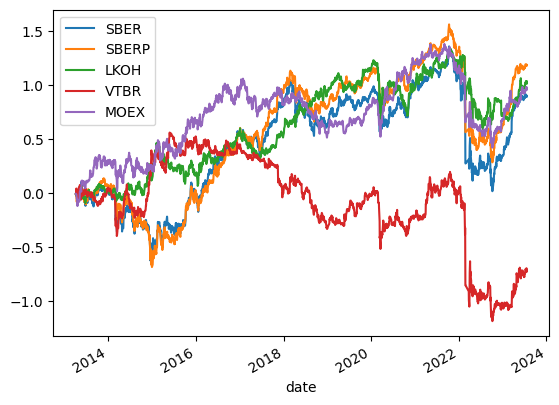

In [4]:
df_returns_real.cumsum().plot()
plt.show()

# GAN TCN


In [5]:
from constants import DEVICE

print(f'Use device: {DEVICE}')

Use device: cpu


In [6]:
from gan import Discriminator, Generator

assert Discriminator()(next(iter(dataloader))).size() == (BATCH_SIZE,)
assert Generator()(Generator.get_noise(BATCH_SIZE)).size() == next(iter(dataloader)).size()

C:\Python\Lib\site-packages\torch\nn\utils\weight_norm.py:143: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)


## Train

50 epochs train time: 482.5s. Estimated train time: 32.2m
Fake std: [0.02790814 0.0235179  0.02169286 0.02565646 0.02313255].
Real std: [0.02243834 0.01917073 0.02287722 0.02141348 0.0187115 ]
Fake correlation: 0.7512544563103505. Real correlation: 0.9197504933566062


C:\Users\an.v.potapov\Desktop\учеба\ФТИАД\курсач\код максима\aa\library\gan_train_loop.py:89: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f'Fake correlation: {df_returns_fake[plot_columns].corr().iloc[0][1]}. Real correlation: {df_returns_real[plot_columns].corr().iloc[0][1]}')
C:\Users\an.v.potapov\Desktop\учеба\ФТИАД\курсач\код максима\aa\library\gan_train_loop.py:89: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f'Fake correlation: {df_returns_fake[plot_columns].corr().iloc[0][1]}. Real correlation: {df_returns_real[plot_columns].corr().iloc[0][1]}')


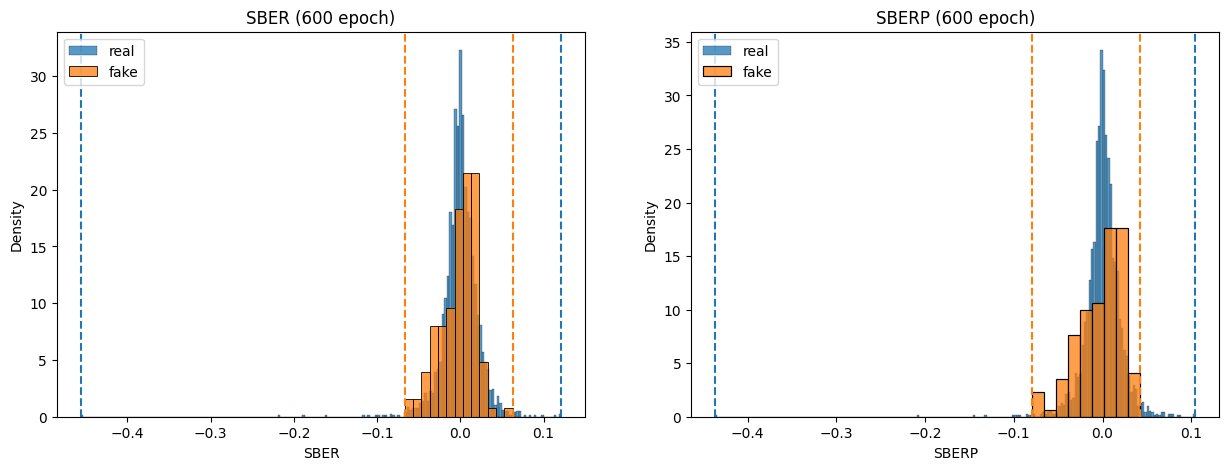

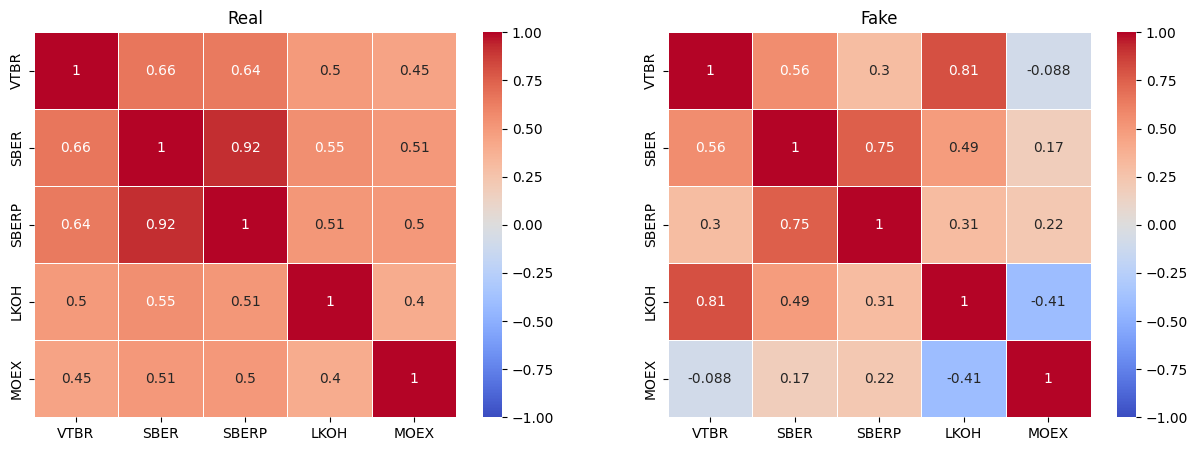

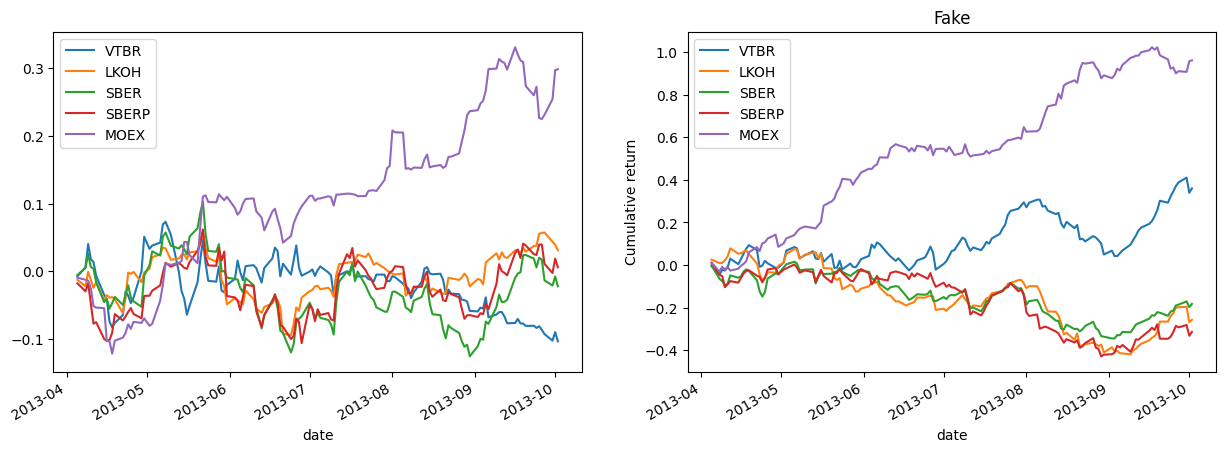

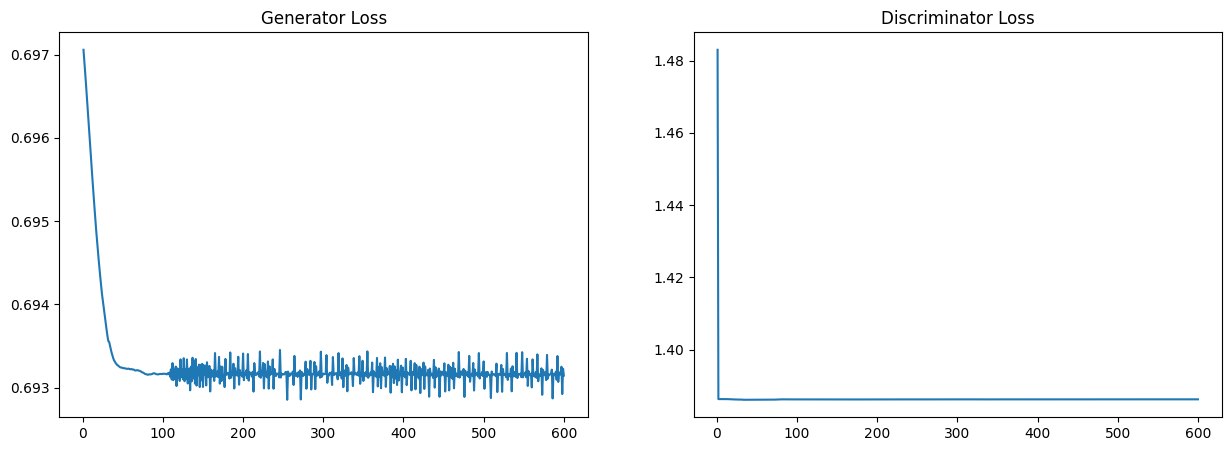

In [ ]:
from gan_train_loop import train_gan

N_EPOCHS = 800
LOG_FREQUENCY = 50
SAVE_FREQUENCY = 200

# Define generator and discriminator
discriminator = Discriminator().to(DEVICE)
generator = Generator().to(DEVICE)

# Define the optimizers for generator and discriminator
LR = 0.0002
generator_optimizer = optim.RMSprop(generator.parameters(), lr=LR)
discriminator_optimizer = optim.RMSprop(discriminator.parameters(), lr=LR)

# Train GAN
discriminator_losses, generator_losses = train_gan(generator, discriminator, generator_optimizer, discriminator_optimizer, dataloader, df_returns_real, n_epochs=N_EPOCHS, log_frequency=LOG_FREQUENCY, save_frequency=SAVE_FREQUENCY, model_prefix='TCN')

In [ ]:
plt.plot(generator_losses[10:])
plt.show()
plt.plot(discriminator_losses[10:])
plt.show()

# Generation

## Generate random history

In [10]:
from gan_train_loop import load_gan

generator = Generator().to(DEVICE)
load_gan('TCN', generator, epoch=900)

Load 900 epoch checkpoint
models\TCN\checkpoint_900


C:\Users\an.v.potapov\Desktop\учеба\ФТИАД\курсач\код максима\aa\library\gan_train_loop.py:188: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_pa

In [11]:
Generator()

Generator(
  (tcn): ModuleList(
    (0): TemporalBlock(
      (conv1): Conv1d(15, 10, kernel_size=(1,), stride=(1,))
      (chomp1): Chomp1d()
      (relu1): ReLU()
      (dropout1): Dropout(p=0.2, inplace=False)
      (conv2): Conv1d(10, 10, kernel_size=(1,), stride=(1,))
      (chomp2): Chomp1d()
      (relu2): ReLU()
      (dropout2): Dropout(p=0.2, inplace=False)
      (net): Sequential(
        (0): Conv1d(15, 10, kernel_size=(1,), stride=(1,))
        (1): ReLU()
        (2): Dropout(p=0.2, inplace=False)
        (3): Conv1d(10, 10, kernel_size=(1,), stride=(1,))
        (4): ReLU()
        (5): Dropout(p=0.2, inplace=False)
      )
      (downsample): Conv1d(15, 10, kernel_size=(1,), stride=(1,))
      (relu): ReLU()
    )
    (1): TemporalBlock(
      (conv1): Conv1d(10, 10, kernel_size=(2,), stride=(1,), padding=(1,))
      (chomp1): Chomp1d()
      (relu1): ReLU()
      (dropout1): Dropout(p=0.2, inplace=False)
      (conv2): Conv1d(10, 10, kernel_size=(2,), stride=(1,), padd

In [12]:
from generation import generate_fake_returns
print(df_returns_real.shape)
df_returns_fake = generate_fake_returns(generator, df_returns_real, seed=0)

(2691, 5)
2566
shape after merg (2691, 5)


## Plot cumulative real and fake returns

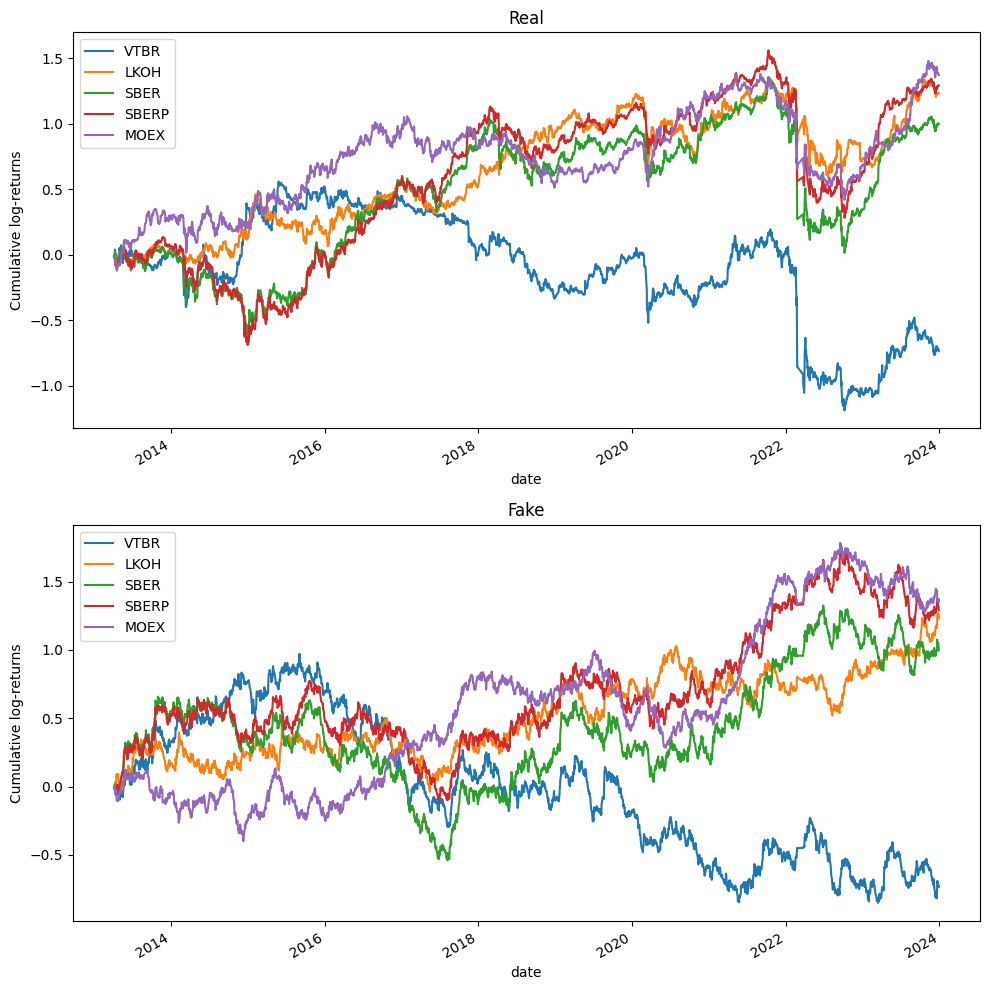

In [43]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))

plt.subplot(2, 1, 1)

df_returns_real.cumsum().plot(ax=ax1)
plt.title('Real')
plt.ylabel('Cumulative log-returns')

plt.subplot(2, 1, 2)
df_returns_fake.cumsum().plot(ax=ax2)
plt.title('Fake')
plt.ylabel('Cumulative log-returns')
plt.tight_layout()

plt.show()

## Plot correlation matrix for real and fake returns

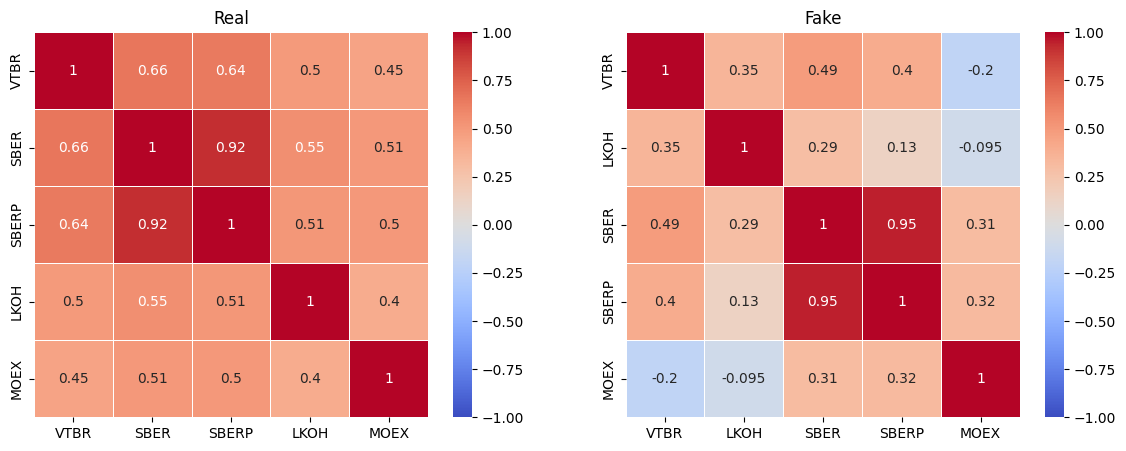

In [23]:
from correlations import plot_correlation_matrix

plt.subplots(1, 2, figsize=(14, 5))

plt.subplot(1, 2, 1)
plot_correlation_matrix(df_returns_real.corr())
plt.title('Real')

plt.subplot(1, 2, 2)
plot_correlation_matrix(df_returns_fake.corr())
plt.title('Fake')

plt.show()

# Plot returns distribution

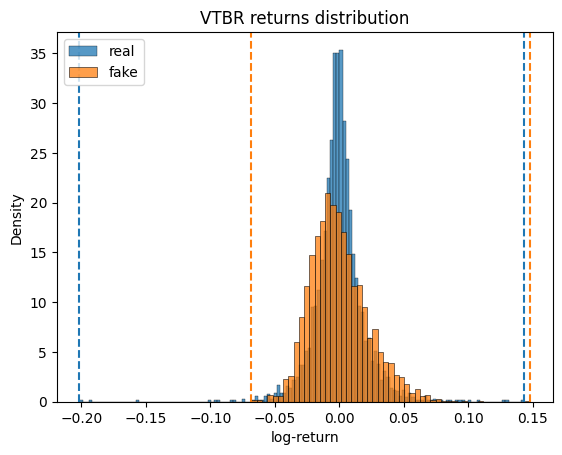

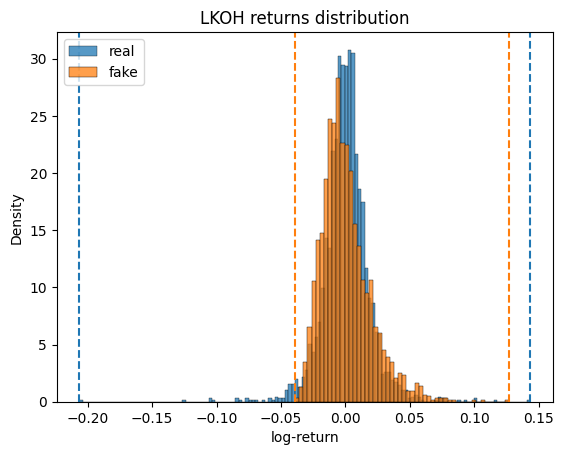

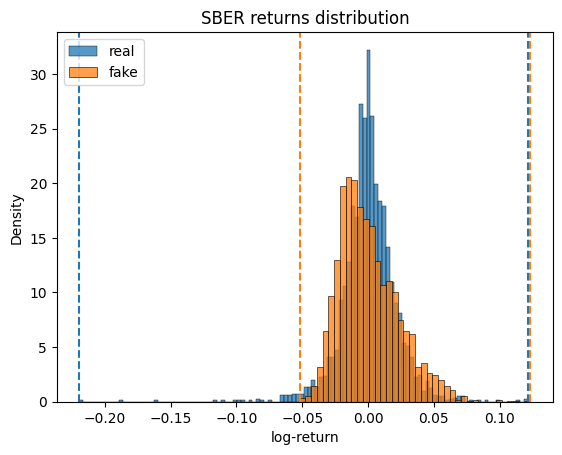

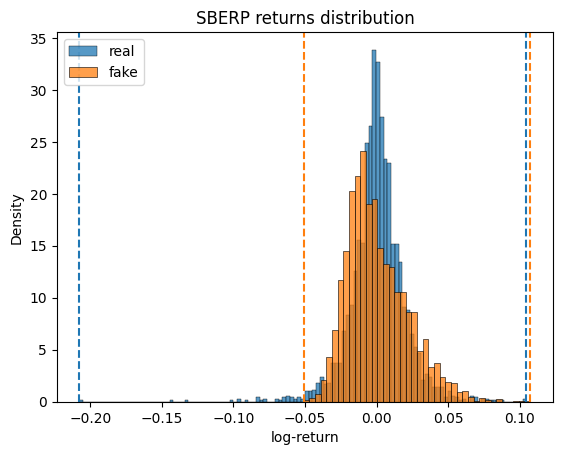

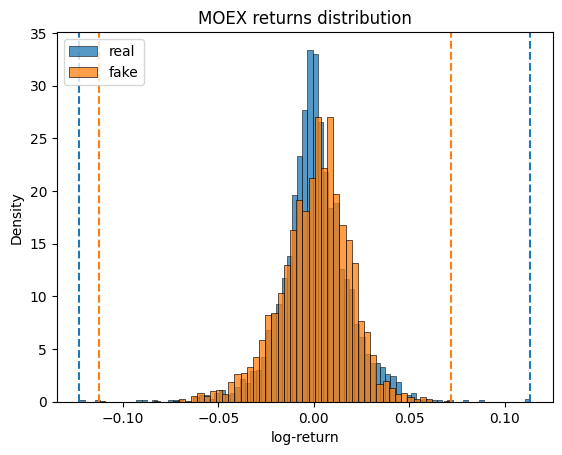

In [24]:
tmp_df_returns_real = df_returns_real[df_returns_real.sum(axis=1) != df_returns_real.sum(axis=1).min()]

for col in df_returns_real.columns:
    # Plot returns distributions
    sns.histplot(tmp_df_returns_real[col], stat='density', label='real')
    sns.histplot(df_returns_fake[col], stat='density', label='fake')

    # Plot real returns bounds
    plt.axvline(tmp_df_returns_real[col].min(), linestyle='dashed', color='C0')
    plt.axvline(tmp_df_returns_real[col].max(), linestyle='dashed', color='C0')

    # Plot fake returns bounds
    plt.axvline(df_returns_fake[col].min(), linestyle='dashed', color='C1')
    plt.axvline(df_returns_fake[col].max(), linestyle='dashed', color='C1')

    plt.xlabel('log-return')
    plt.legend(loc='upper left')
    plt.title(f'{col} returns distribution')
    plt.show()

In [1]:
import numpy
numpy.version.version


'1.26.4'

# GAN MLP

In [7]:
from dataset import get_pytorch_datataset, BATCH_SIZE

df_returns_real, dataset, dataloader, N_ASSETS, WINDOW_SIZE = get_pytorch_datataset()

print(f'\nDataset length: {len(dataset)}')
print(f'Number of assets: {N_ASSETS}')
sample_batch = next(iter(dataloader))
assert sample_batch.size() == (BATCH_SIZE, N_ASSETS, WINDOW_SIZE)
print(f'Sample batch: {sample_batch.size()}')

Chosen tickers: ['SBER', 'SBERP', 'LKOH', 'VTBR', 'MOEX']
Length before dropping NaNs: 2603
Length after dropping NaNs: 2577

Dataset length: 2451
Number of assets: 5
Sample batch: torch.Size([256, 5, 126])


In [8]:
from constants import DEVICE

print(f'Use device: {DEVICE}')

Use device: cpu


In [9]:
from gan_MLP import Discriminator, Generator


assert Discriminator()(next(iter(dataloader))).size() == (BATCH_SIZE,)
# assert Generator()(Generator.get_noise(BATCH_SIZE)).size() == next(iter(dataloader)).size()

C:\Python\Lib\site-packages\torch\nn\utils\weight_norm.py:143: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)


In [10]:
Generator()

Generator(
  (mlp): MLP(
    (layers): ModuleList(
      (0): Linear(in_features=1260, out_features=100, bias=True)
      (1-3): 3 x Linear(in_features=100, out_features=100, bias=True)
      (4): Linear(in_features=100, out_features=630, bias=True)
    )
    (relu): ReLU()
  )
)

  0%|          | 0/500 [00:00<?, ?it/s]

100 epochs train time: 398.8s. Estimated train time: 26.6m
1 torch.Size([1, 630])
Fake std: [0.06280845 0.06071563 0.06940456 0.06488611 0.06231484].
Real std: [0.02320357 0.02170969 0.01934618 0.02256658 0.01871406]
Fake correlation: 0.08938059450332558. Real correlation: 0.9185647795211369


C:\Users\an.v.potapov\Desktop\учеба\ФТИАД\курсач\mometum_gan\library\gan_train_loop_MLP.py:95: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f'Fake correlation: {df_returns_fake[plot_columns].corr().iloc[0][1]}. Real correlation: {df_returns_real[plot_columns].corr().iloc[0][1]}')
C:\Users\an.v.potapov\Desktop\учеба\ФТИАД\курсач\mometum_gan\library\gan_train_loop_MLP.py:95: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f'Fake correlation: {df_returns_fake[plot_columns].corr().iloc[0][1]}. Real correlation: {df_returns_real[plot_columns].corr().iloc[0][1]}')


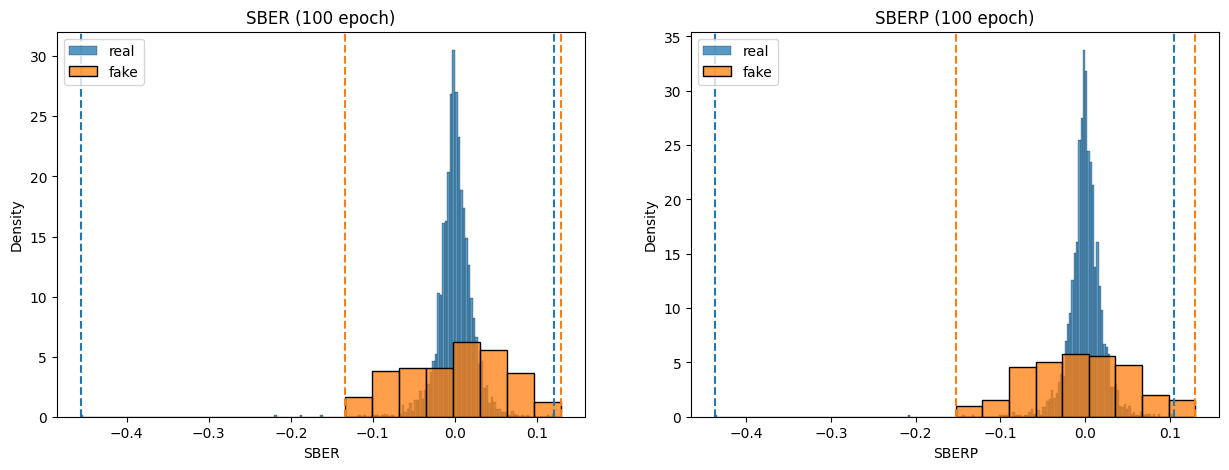

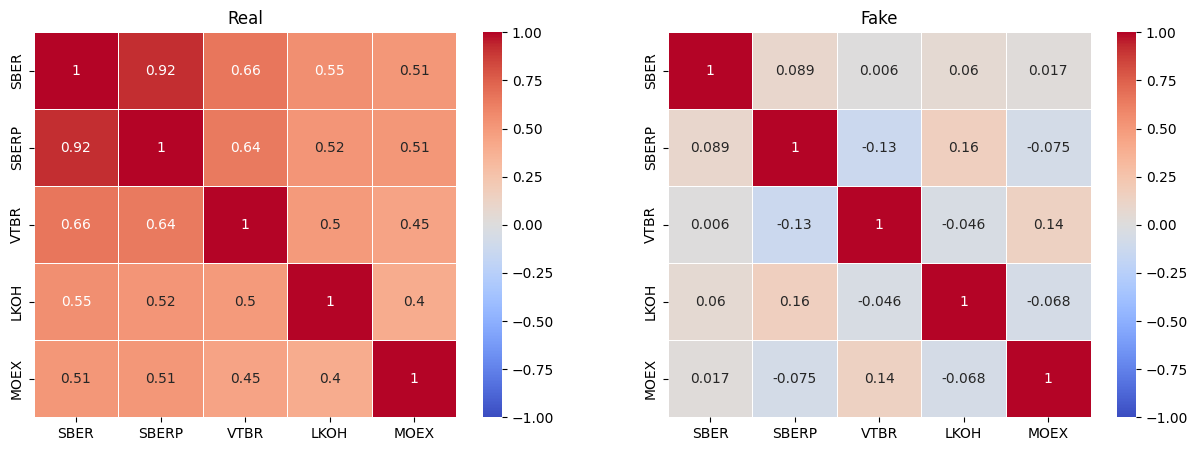

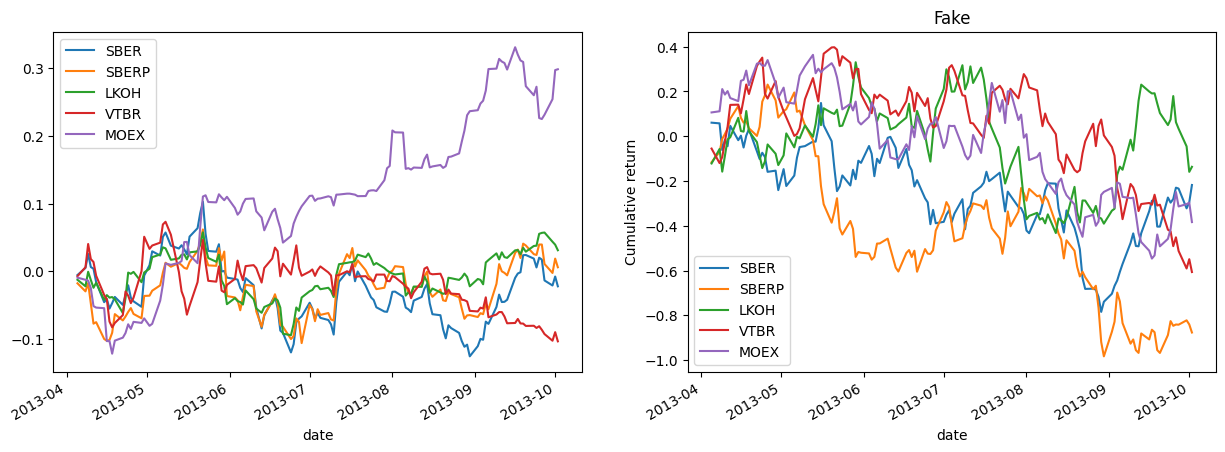

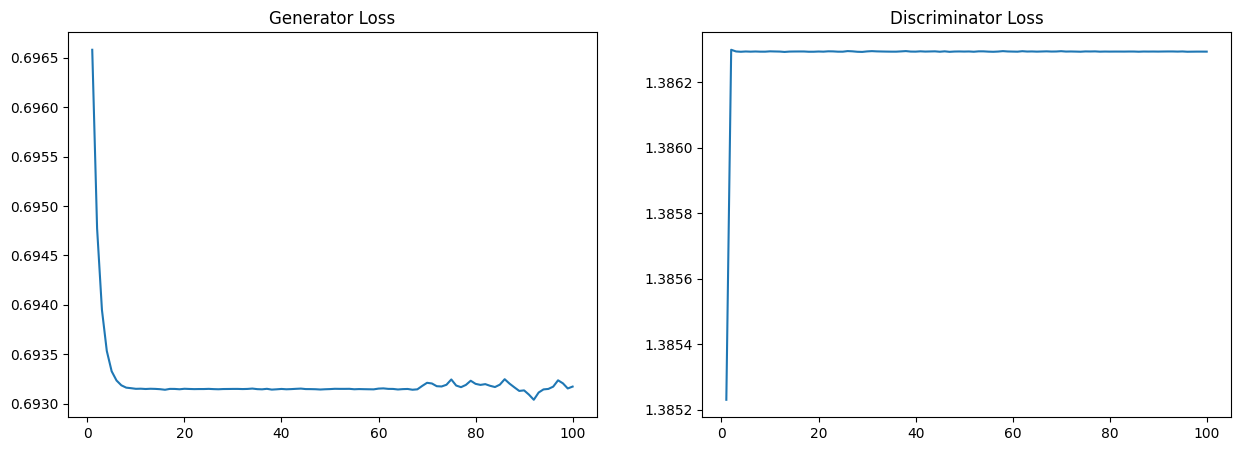

100 epochs train time: 460.7s. Estimated train time: 23.0m
1 torch.Size([1, 630])
Fake std: [0.05161307 0.03467222 0.03534969 0.04729414 0.05145032].
Real std: [0.02320357 0.02170969 0.01934618 0.02256658 0.01871406]
Fake correlation: 0.020814223838922057. Real correlation: 0.9185647795211369


C:\Users\an.v.potapov\Desktop\учеба\ФТИАД\курсач\mometum_gan\library\gan_train_loop_MLP.py:95: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f'Fake correlation: {df_returns_fake[plot_columns].corr().iloc[0][1]}. Real correlation: {df_returns_real[plot_columns].corr().iloc[0][1]}')
C:\Users\an.v.potapov\Desktop\учеба\ФТИАД\курсач\mometum_gan\library\gan_train_loop_MLP.py:95: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f'Fake correlation: {df_returns_fake[plot_columns].corr().iloc[0][1]}. Real correlation: {df_returns_real[plot_columns].corr().iloc[0][1]}')


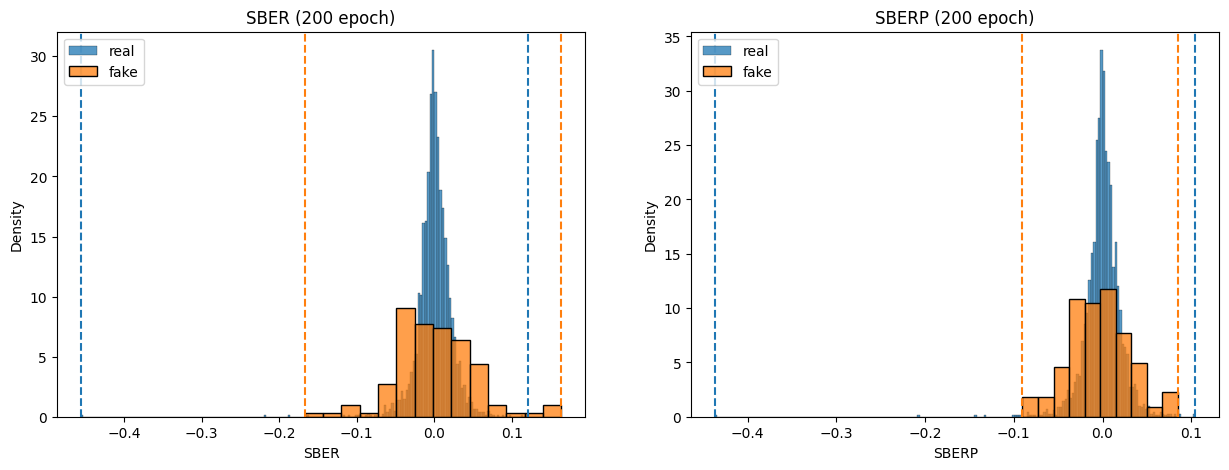

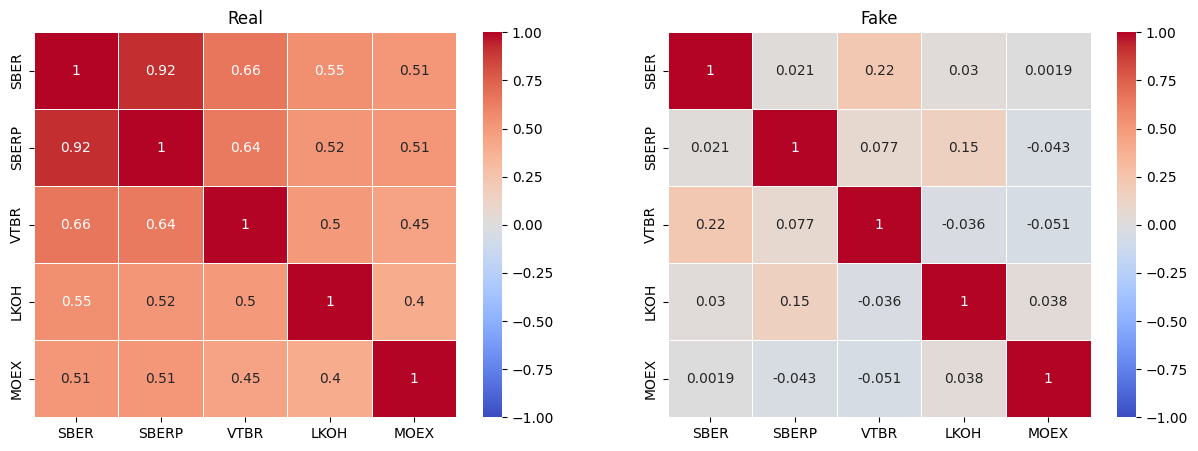

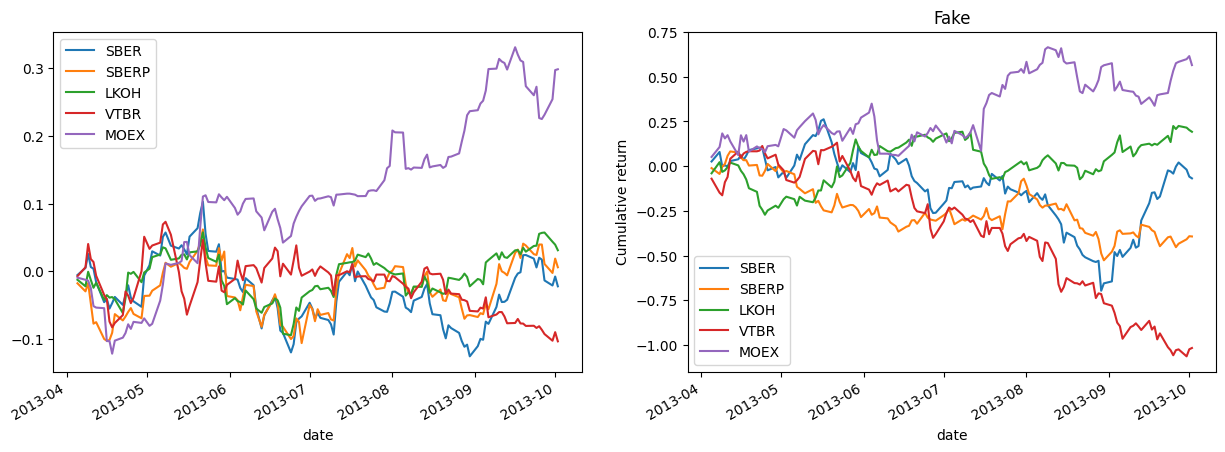

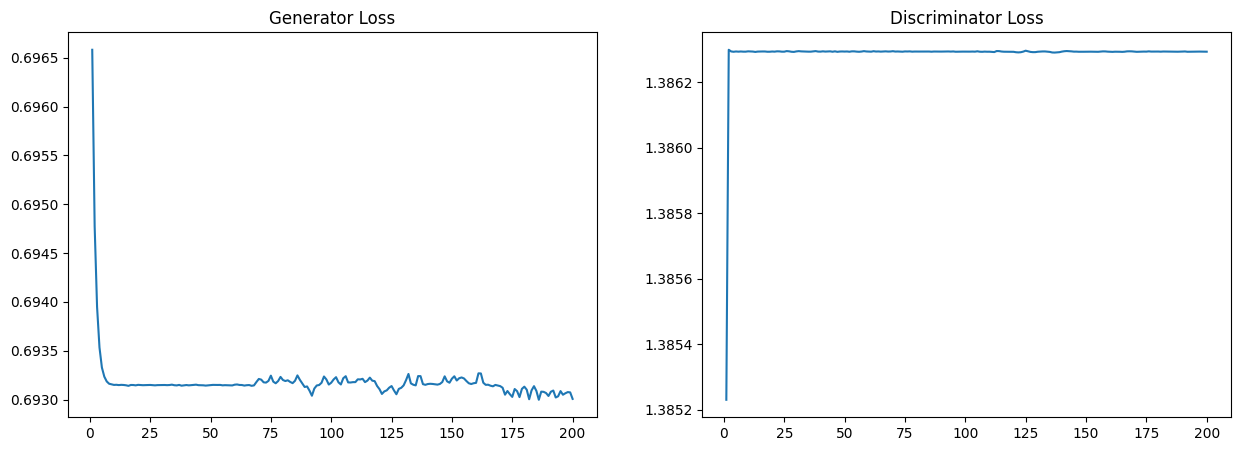

100 epochs train time: 876.7s. Estimated train time: 29.2m
1 torch.Size([1, 630])
Fake std: [0.03825599 0.02633192 0.02382536 0.03249443 0.0325024 ].
Real std: [0.02320357 0.02170969 0.01934618 0.02256658 0.01871406]
Fake correlation: 0.7098685508676604. Real correlation: 0.9185647795211369


C:\Users\an.v.potapov\Desktop\учеба\ФТИАД\курсач\mometum_gan\library\gan_train_loop_MLP.py:95: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f'Fake correlation: {df_returns_fake[plot_columns].corr().iloc[0][1]}. Real correlation: {df_returns_real[plot_columns].corr().iloc[0][1]}')
C:\Users\an.v.potapov\Desktop\учеба\ФТИАД\курсач\mometum_gan\library\gan_train_loop_MLP.py:95: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f'Fake correlation: {df_returns_fake[plot_columns].corr().iloc[0][1]}. Real correlation: {df_returns_real[plot_columns].corr().iloc[0][1]}')


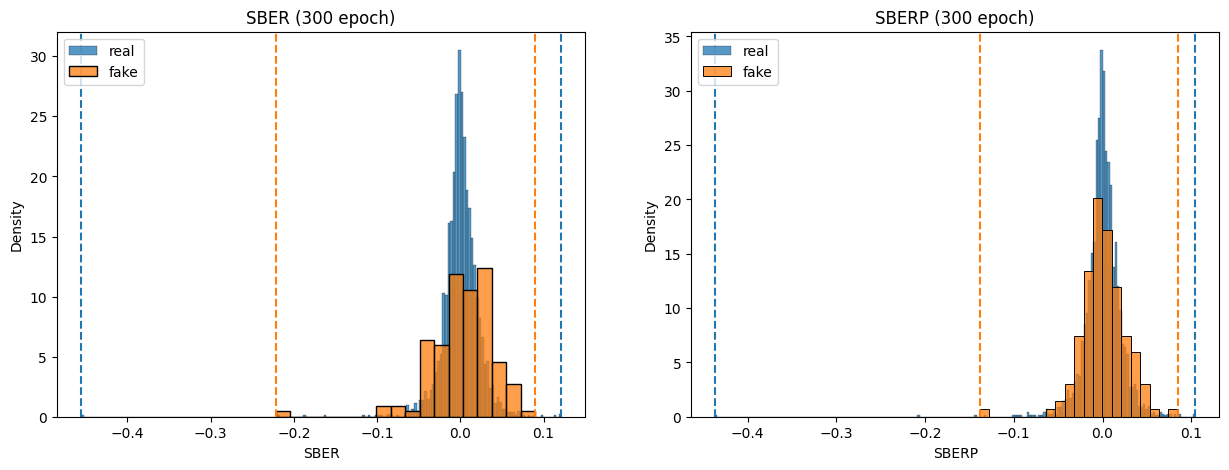

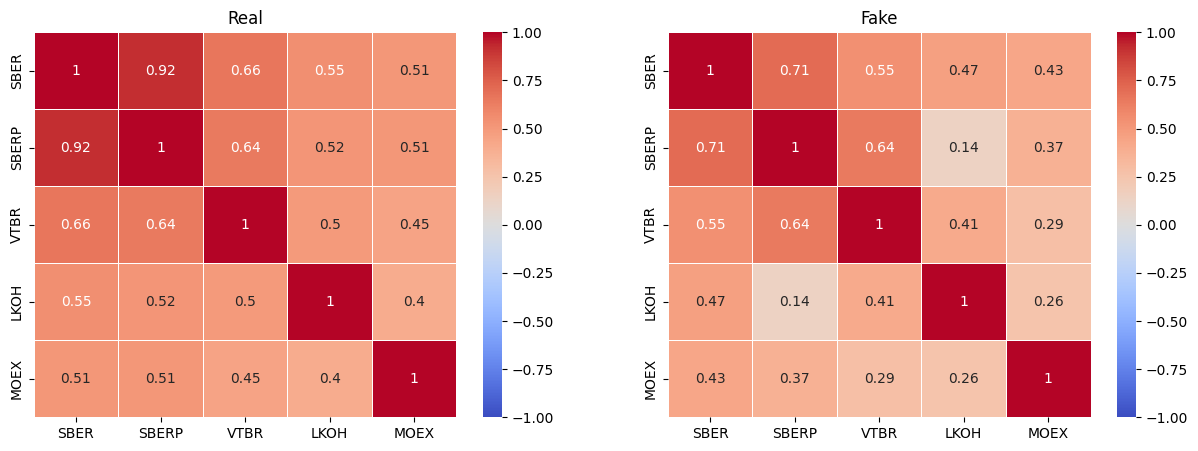

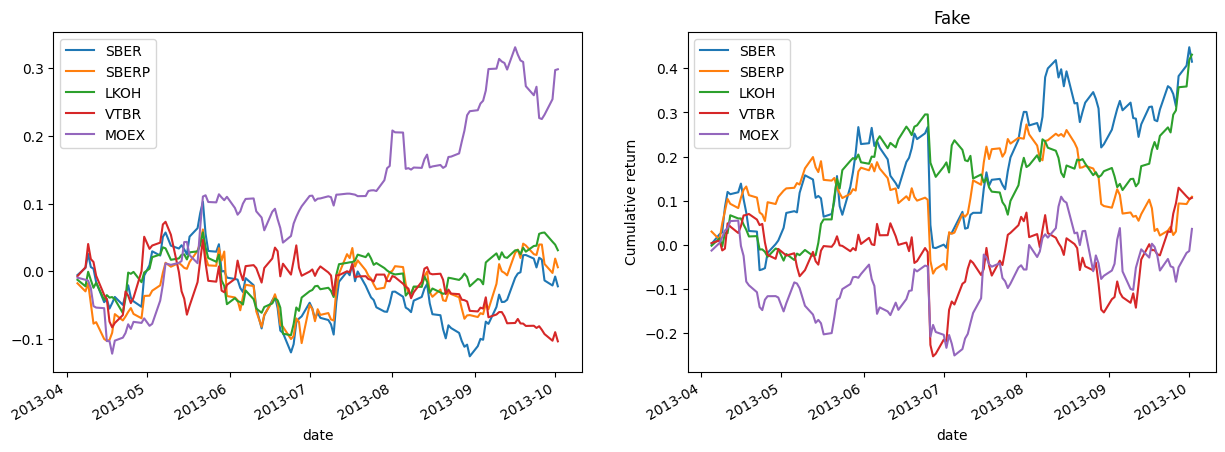

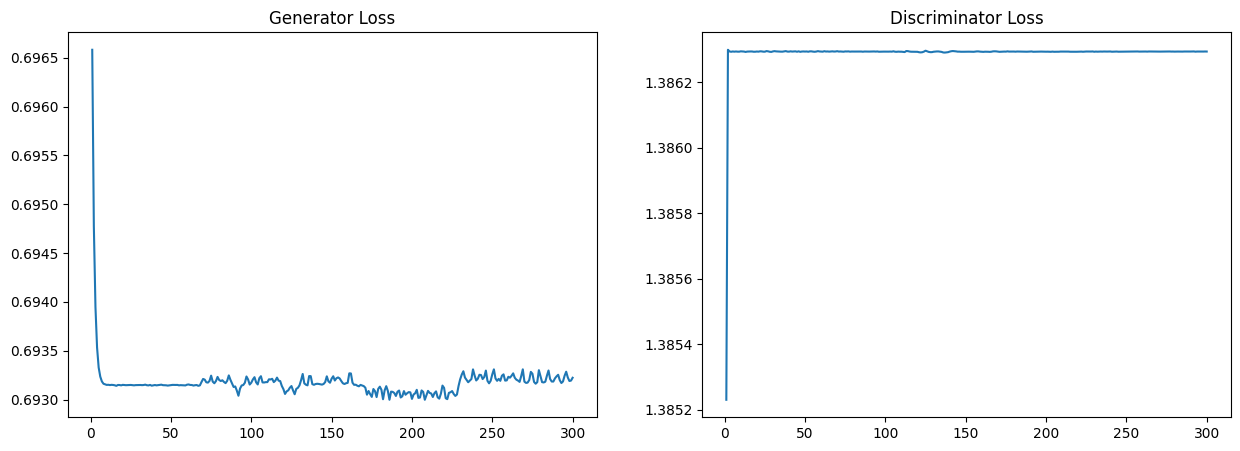

100 epochs train time: 873.4s. Estimated train time: 14.6m
1 torch.Size([1, 630])
Fake std: [0.03846334 0.02774326 0.02884591 0.03308218 0.03016007].
Real std: [0.02320357 0.02170969 0.01934618 0.02256658 0.01871406]
Fake correlation: 0.7489621640632623. Real correlation: 0.9185647795211369


C:\Users\an.v.potapov\Desktop\учеба\ФТИАД\курсач\mometum_gan\library\gan_train_loop_MLP.py:95: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f'Fake correlation: {df_returns_fake[plot_columns].corr().iloc[0][1]}. Real correlation: {df_returns_real[plot_columns].corr().iloc[0][1]}')
C:\Users\an.v.potapov\Desktop\учеба\ФТИАД\курсач\mometum_gan\library\gan_train_loop_MLP.py:95: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f'Fake correlation: {df_returns_fake[plot_columns].corr().iloc[0][1]}. Real correlation: {df_returns_real[plot_columns].corr().iloc[0][1]}')


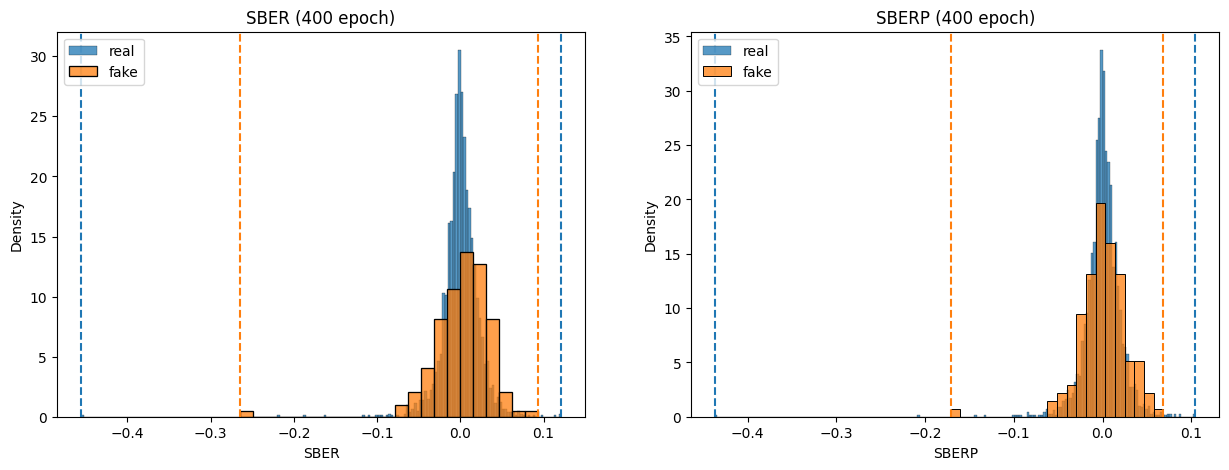

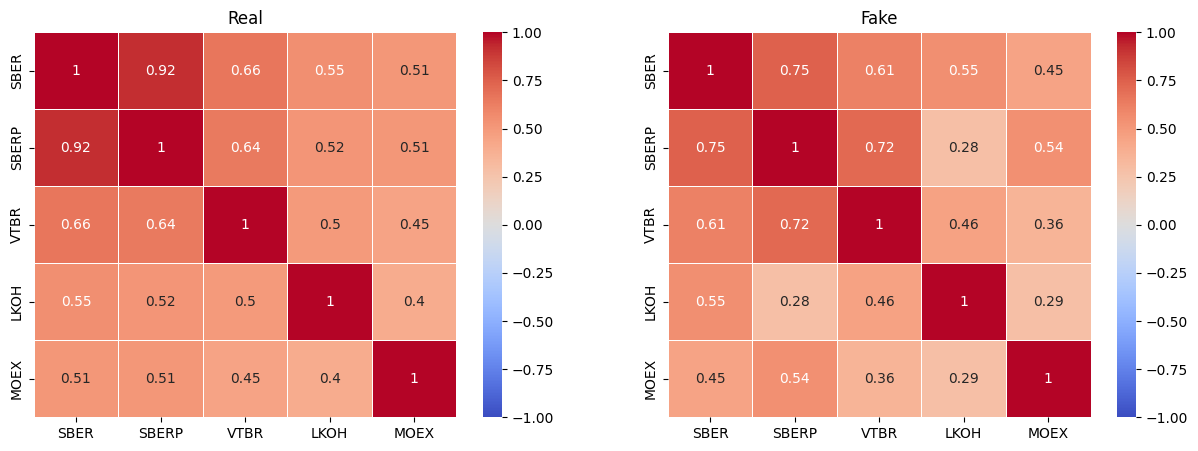

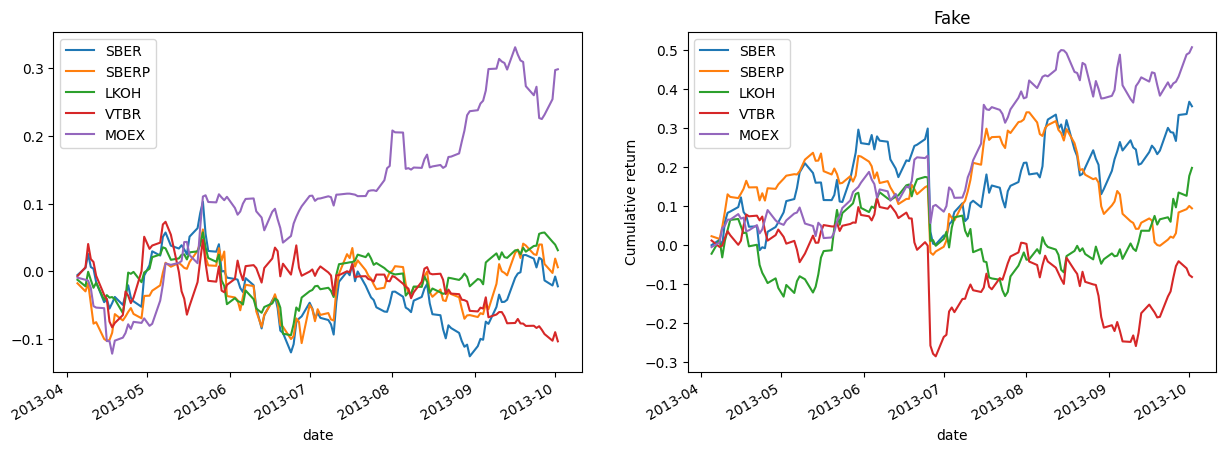

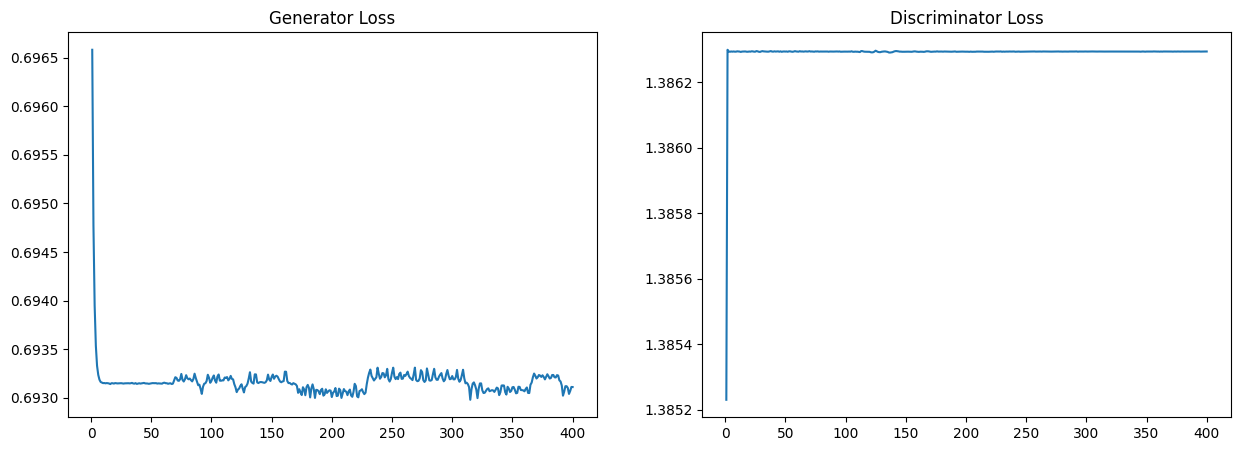

100 epochs train time: 884.6s. Estimated train time: 0.0m
1 torch.Size([1, 630])
Fake std: [0.03945544 0.02893764 0.02751772 0.03391393 0.0304793 ].
Real std: [0.02320357 0.02170969 0.01934618 0.02256658 0.01871406]
Fake correlation: 0.7538711595642534. Real correlation: 0.9185647795211369


C:\Users\an.v.potapov\Desktop\учеба\ФТИАД\курсач\mometum_gan\library\gan_train_loop_MLP.py:95: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f'Fake correlation: {df_returns_fake[plot_columns].corr().iloc[0][1]}. Real correlation: {df_returns_real[plot_columns].corr().iloc[0][1]}')
C:\Users\an.v.potapov\Desktop\учеба\ФТИАД\курсач\mometum_gan\library\gan_train_loop_MLP.py:95: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f'Fake correlation: {df_returns_fake[plot_columns].corr().iloc[0][1]}. Real correlation: {df_returns_real[plot_columns].corr().iloc[0][1]}')


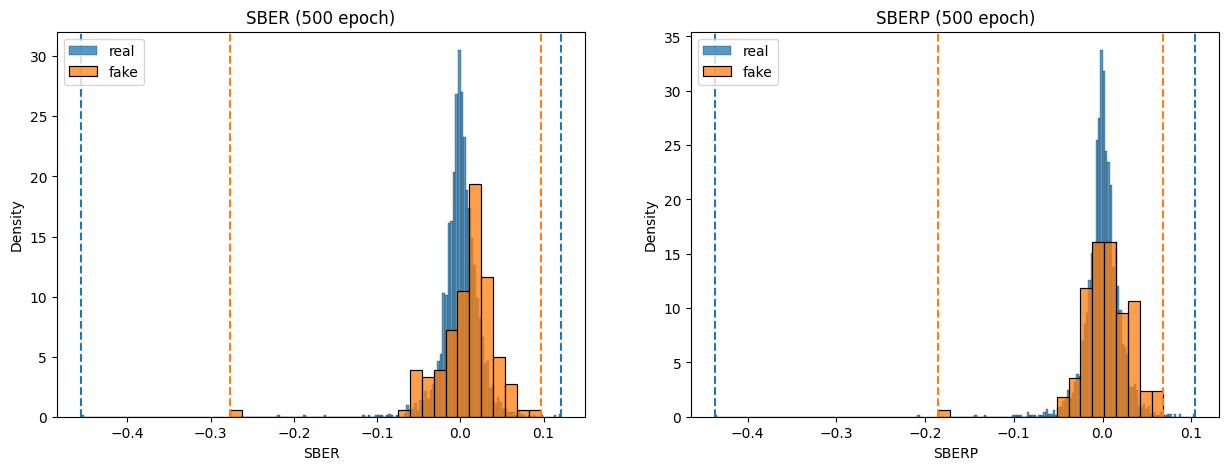

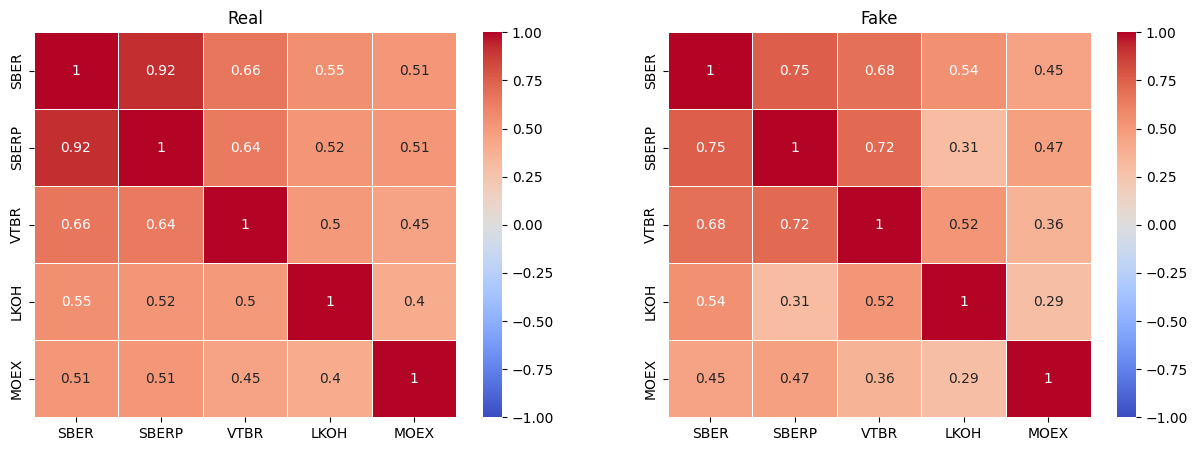

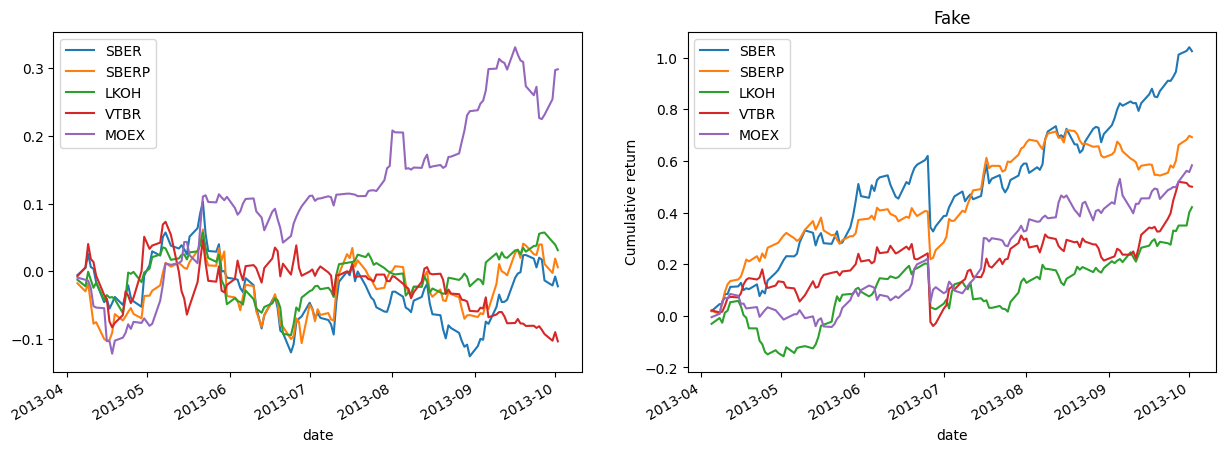

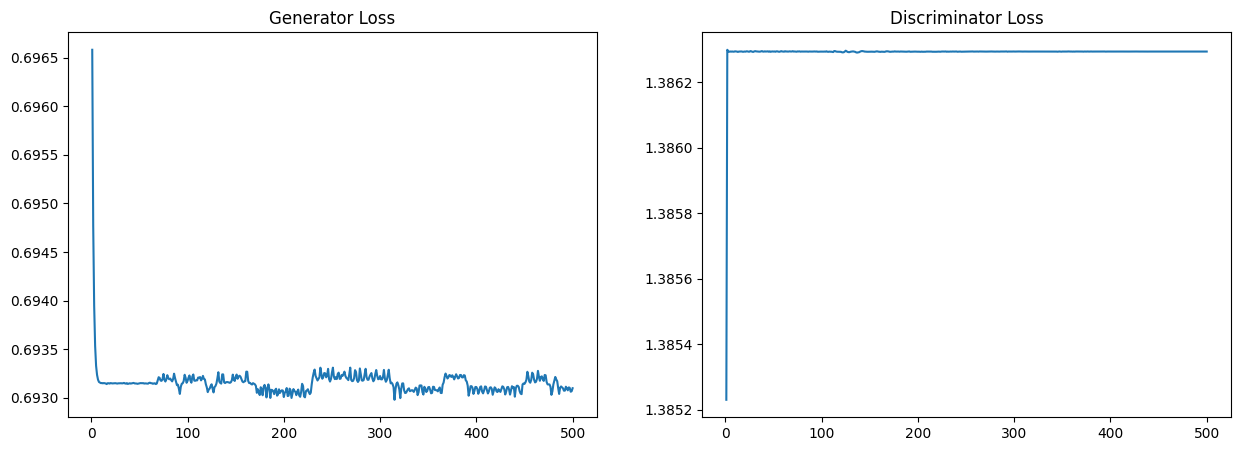

In [16]:
from gan_train_loop_MLP import train_gan

N_EPOCHS = 500
LOG_FREQUENCY = 100
SAVE_FREQUENCY = 100

torch.manual_seed(1) # добавил, чтобы генерации были одинаковыми
# Define generator and discriminator
discriminator = Discriminator().to(DEVICE)
generator = Generator().to(DEVICE)

# Define the optimizers for generator and discriminator
LR = 0.0002
generator_optimizer = optim.RMSprop(generator.parameters(), lr=LR)
discriminator_optimizer = optim.RMSprop(discriminator.parameters(), lr=LR)

# Train GAN
discriminator_losses_mlp, generator_losses_mlp = train_gan(generator, discriminator, generator_optimizer, discriminator_optimizer, dataloader, df_returns_real, n_epochs=N_EPOCHS, log_frequency=LOG_FREQUENCY, save_frequency=SAVE_FREQUENCY, model_prefix='MLP')

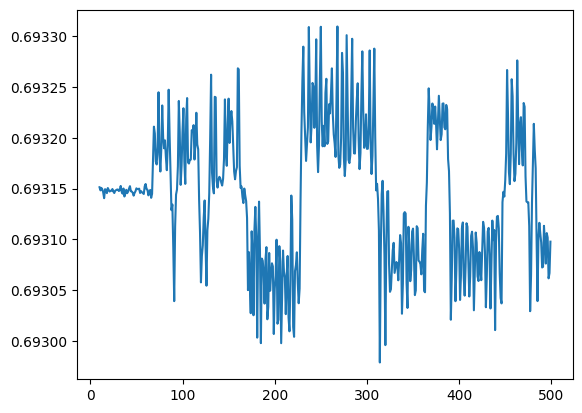

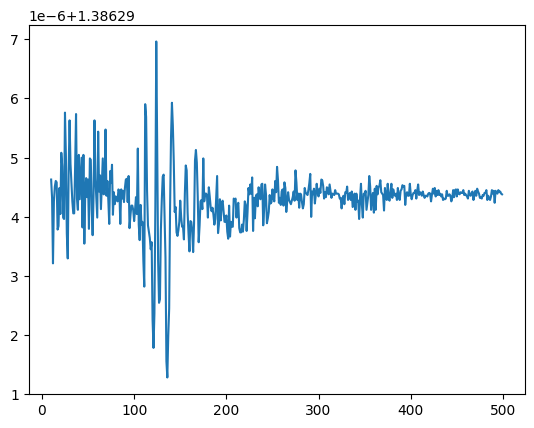

In [17]:
plt.plot(range(10, len(discriminator_losses_mlp)), discriminator_losses_mlp[10:])
plt.show()
plt.plot(range(10, len(generator_losses_mlp)), generator_losses_mlp[10:])
plt.show()

# Generate rand history

In [17]:
from gan_train_loop_MLP import load_gan

generator = Generator().to(DEVICE)
load_gan('MLP', generator, epoch=300)

models\MLP
Load 300 epoch checkpoint
models\MLP\checkpoint_300


In [18]:
from generation_MLP import generate_fake_returns
print(df_returns_real.shape)
df_returns_fake = generate_fake_returns(generator, df_returns_real, seed=0)

(2576, 5)
2451 torch.Size([2451, 630])
2451
shape after merg (2576, 5)


<Axes: xlabel='date'>

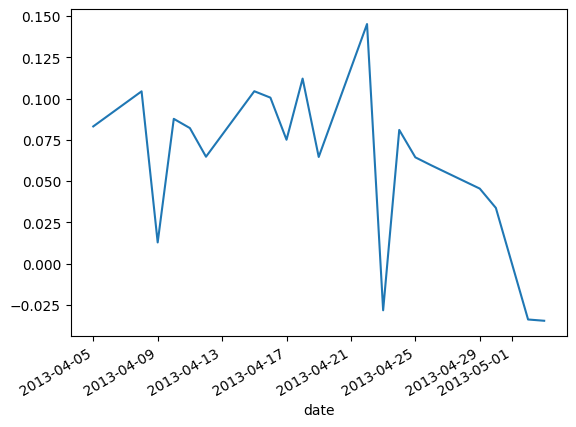

In [19]:
df_returns_fake[:20]['VTBR'].plot()

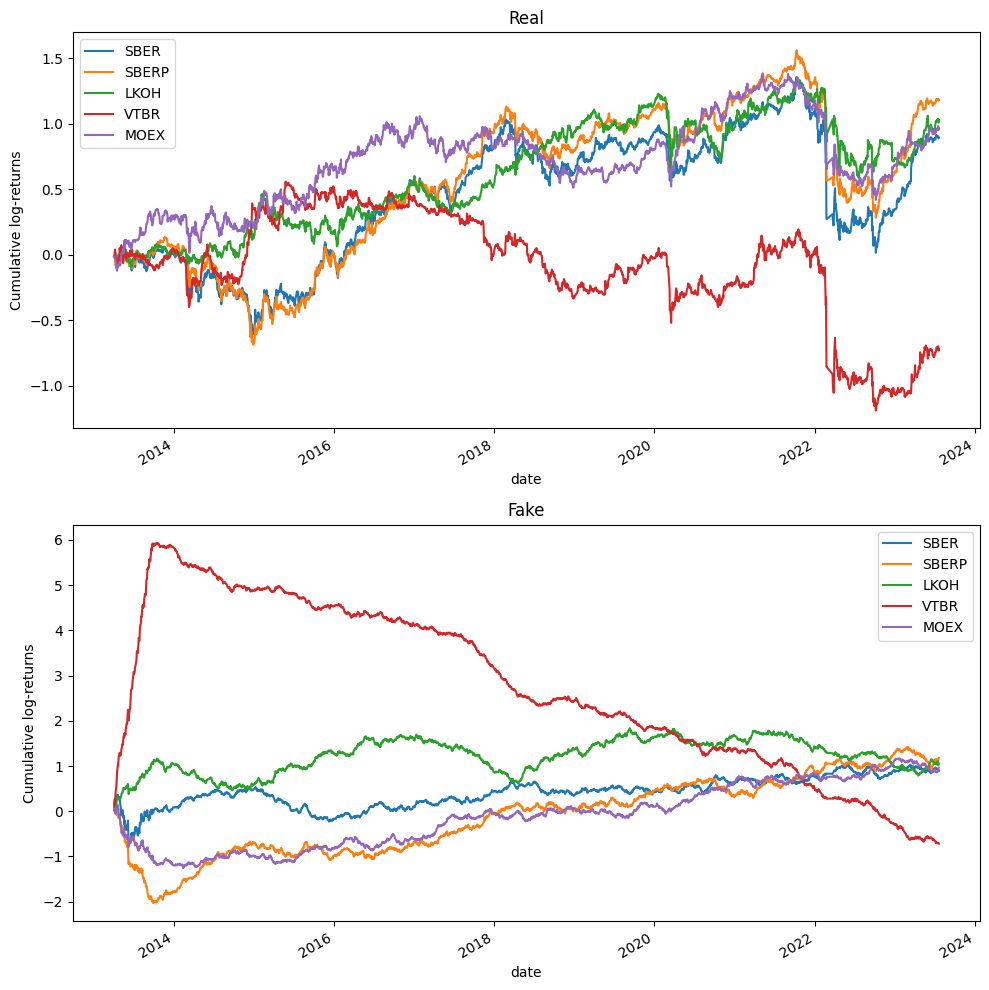

In [25]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))

plt.subplot(2, 1, 1)

df_returns_real.cumsum().plot(ax=ax1)
plt.title('Real')
plt.ylabel('Cumulative log-returns')

plt.subplot(2, 1, 2)
df_returns_fake.cumsum().plot(ax=ax2)
plt.title('Fake')
plt.ylabel('Cumulative log-returns')
plt.tight_layout()

plt.show()

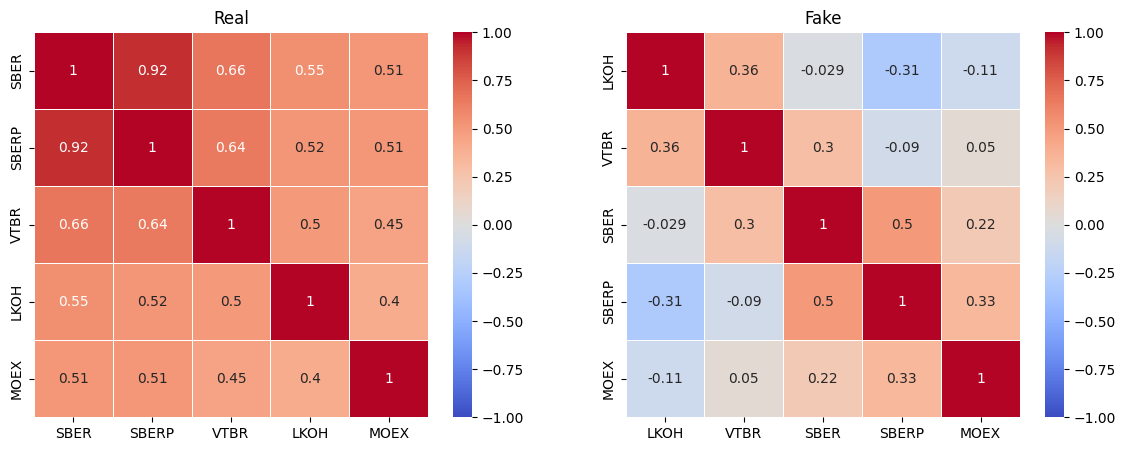

In [21]:
from correlations import plot_correlation_matrix

plt.subplots(1, 2, figsize=(14, 5))

plt.subplot(1, 2, 1)
plot_correlation_matrix(df_returns_real.corr())
plt.title('Real')

plt.subplot(1, 2, 2)
plot_correlation_matrix(df_returns_fake.corr())
plt.title('Fake')

plt.show()

# Battlefield

In [26]:
from gan_train_loop_MLP import load_gan

generator = Generator().to(DEVICE)
load_gan('MLP', generator, epoch=300)

models\MLP
Load 300 epoch checkpoint
models\MLP\checkpoint_300


In [27]:
from generation_MLP import generate_fake_returns
print(df_returns_real.shape)
df_returns_fake = generate_fake_returns(generator, df_returns_real, seed=0)

(2576, 5)
2451 torch.Size([2451, 630])
2451
shape after merg (2576, 5)


In [33]:
Generator.get_shifted_noise(1).shape

torch.Size([1, 1260])

In [ ]:
from generation_MLP import generate_fake_returns
print(df_returns_real.shape)
df_returns_fake = generate_fake_returns(generator, df_returns_real, seed=0)